### Programa Principal:

In [15]:
from src import OWID
from utilities import DataFrameTransform
from utilities import Currency
from utilities import DataBaseSQLite3
import pandas as pd
import matplotlib.pyplot as plt

### 1) Solar photovoltaic capacity:

`Extração de Dados da API OWID`

In [16]:
solar_capacity: OWID = OWID('solar-pv-cumulative-capacity')
pdf_solar_capacity: pd.DataFrame = solar_capacity.slug_into_dataframe()
pdf_solar_capacity

,entities,years,solar_pv_cumulative_capacity
0,United Kingdom,2000,0.002000
1,France,2000,0.007000
2,Netherlands,2000,0.013000
3,Germany,2000,0.114000
4,Switzerland,2000,0.016000
...,...,...,...
4275,Oceania (IRENA),2022,27.396540
4276,Central America and the Caribbean (IRENA),2022,3.986619
4277,North America (IRENA),2022,124.946010
4278,South America (IRENA),2022,32.664700


`Tratamento dos nomes das Colunas`

In [17]:
pdf_solar_capacity: pd.DataFrame = DataFrameTransform.transform_column(pdf_solar_capacity, 'entities', 'País')
pdf_solar_capacity: pd.DataFrame = DataFrameTransform.transform_column(pdf_solar_capacity, 'years', 'Ano')
pdf_solar_capacity: pd.DataFrame = DataFrameTransform.transform_column(pdf_solar_capacity, 'solar_pv_cumulative_capacity', 'Capacidade Acumulada [GW]')
pdf_solar_capacity

,País,Ano,Capacidade Acumulada [GW]
0,United Kingdom,2000,0.002000
1,France,2000,0.007000
2,Netherlands,2000,0.013000
3,Germany,2000,0.114000
4,Switzerland,2000,0.016000
...,...,...,...
4275,Oceania (IRENA),2022,27.396540
4276,Central America and the Caribbean (IRENA),2022,3.986619
4277,North America (IRENA),2022,124.946010
4278,South America (IRENA),2022,32.664700


`Tratamento de Null e Tipos de Dados`

In [18]:
pdf_solar_capacity.info()   #Todas as linhas estão preenchidas e com os tipos corretos. Sem Necessidade de tratamento!

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4280 entries, 0 to 4279
Data columns (total 3 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   País                       4280 non-null   object 
 1   Ano                        4280 non-null   int64  
 2   Capacidade Acumulada [GW]  4280 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 100.4+ KB


`Agrupamento por ano no Mundo (todos os países)`

In [19]:
solar_capacity_group_by_year: pd.DataFrame = pdf_solar_capacity.groupby(by=['Ano']).sum()
solar_capacity_group_by_year: pd.DataFrame = solar_capacity_group_by_year.drop(columns='País')
solar_capacity_group_by_year

,Capacidade Acumulada [GW]
Ano,
2000,4.218612
2001,5.744332
2002,7.545161
2003,10.417443
2004,16.548067
2005,24.998977
2006,33.665242
2007,47.488859
2008,84.000952


### 2) Solar photovoltaic prices:

`Extração de Dados da API OWID`

In [20]:
solar_prices: OWID = OWID('solar-pv-prices')
pdf_solar_prices: pd.DataFrame = solar_prices.slug_into_dataframe()
pdf_solar_prices

,entities,years,solar_pv_prices
0,World,1975,125.833740
1,World,1976,94.675500
2,World,1977,69.070230
3,World,1978,48.867588
4,World,1979,41.060432
5,World,1980,34.795967
6,World,1981,27.820028
7,World,1982,24.995676
8,World,1983,20.179014
9,World,1984,18.750220


`Conversão de Dólar para Real`

In [21]:
pdf_solar_prices['solar_pv_prices'] = pdf_solar_prices['solar_pv_prices'].map(lambda value: Currency(value).converter())
pdf_solar_prices

,entities,years,solar_pv_prices
0,World,1975,701.32
1,World,1976,527.66
2,World,1977,384.96
3,World,1978,272.36
4,World,1979,228.85
5,World,1980,193.93
6,World,1981,155.05
7,World,1982,139.31
8,World,1983,112.47
9,World,1984,104.50


`Tratamento dos nomes das Colunas`

In [22]:
pdf_solar_prices: pd.DataFrame = pdf_solar_prices.drop(columns='entities')
pdf_solar_prices: pd.DataFrame = DataFrameTransform.transform_column(pdf_solar_prices, 'years', 'Ano')
pdf_solar_prices: pd.DataFrame = DataFrameTransform.transform_column(pdf_solar_prices, 'solar_pv_prices', 'R$/W')
pdf_solar_prices

,Ano,R$/W
0,1975,701.32
1,1976,527.66
2,1977,384.96
3,1978,272.36
4,1979,228.85
5,1980,193.93
6,1981,155.05
7,1982,139.31
8,1983,112.47
9,1984,104.50


`Tratamento de Null e Tipos de Dados`

In [23]:
pdf_solar_prices.info()   #Todas as linhas estão preenchidas e com os tipos corretos. Sem Necessidade de tratamento!

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48 entries, 0 to 47
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Ano     48 non-null     int64  
 1   R$/W    48 non-null     float64
dtypes: float64(1), int64(1)
memory usage: 900.0 bytes


### 3) Merge Dataframes

In [24]:
pdf_solar_merge: pd.DataFrame = pd.merge(solar_capacity_group_by_year, pdf_solar_prices, how = 'inner', on = 'Ano')
pdf_solar_merge

,Ano,Capacidade Acumulada [GW],R$/W
0,2000,4.218612,34.41
1,2001,5.744332,33.29
2,2002,7.545161,30.45
3,2003,10.417443,28.95
4,2004,16.548067,24.24
5,2005,24.998977,24.49
6,2006,33.665242,26.70
7,2007,47.488859,26.90
8,2008,84.000952,24.51
9,2009,130.899908,16.38


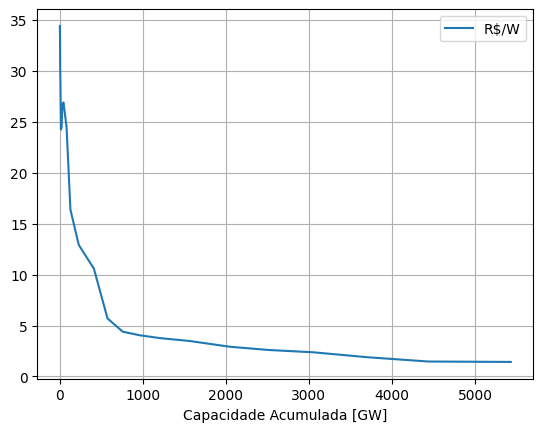

In [25]:
pdf_solar_merge.plot(x='Capacidade Acumulada [GW]', y='R$/W', grid=True);

### Criando Banco de Dados

In [26]:
energia_renovavel: DataBaseSQLite3 = DataBaseSQLite3(db_name = 'energia_renovavel3.db')
energia_renovavel.create_database()

Database energia_renovavel3.db formed.
['__class__', '__delattr__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__iter__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__next__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', 'arraysize', 'close', 'connection', 'description', 'execute', 'executemany', 'executescript', 'fetchall', 'fetchmany', 'fetchone', 'lastrowid', 'row_factory', 'rowcount', 'setinputsizes', 'setoutputsize']


### Carregando Banco de Dados

In [27]:
energia_renovavel.send_dataframe_to_database(
    dataframe = pdf_solar_merge,
    table_name = 'ResumoCapacidadeAnual')

0


### Verificando Dados

In [28]:
energia_renovavel.check_tables_in_database()

connection.total_changes: 0
tables in database energia_renovavel3.db: [('ResumoCapacidadeAnual',)]
